In [1]:
import gensim
import nibabel as nib
from copy import copy
from util import make_delayed
from npp import zscore
import logging
import pickle
from scipy.stats.mstats import zscore

zs = lambda v: (v-v.mean(0))/v.std(0) ## z-score function
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def process_word(word):
    umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss', 
                       u':': u'', u',':'', u'.':'', u'\'': '', u')':'', u'(':'', '?':'', '"':'',
                        u'[':'', u']':'', '!':'', u'…': ''}
    word = word.decode('utf-8')

    for item, val in umlautDictionary.iteritems():
        word = word.replace(item, val)
    
    return word

In [3]:
model = gensim.models.Word2Vec.load_word2vec_format("/home/medanya/forrest_gump/models/download", binary=True)

IOError: [Errno 2] No such file or directory: '/home/medanya/forrest_gump/models/download'

In [4]:
def get_vector(word, model=model):
    try:
        return  model[word]
    except Exception as e:
        try:
            return model[word.title()]
        except Exception as e:
            #print word
            return None

In [5]:
def get_stimulus_matrix(segment_id, gr=False):
    folder_path_read = "/home/medanya/forrest_gump/srt"
    
    if gr:
        file_in = folder_path_read + "/segment{}_words.txt".format(segment_id)
    else:
        file_in = folder_path_read + "/segment{}_words_srt.txt".format(segment_id)
        
    words_times = list()
    words_vectors = list()
    words = list()
    
    with open(file_in) as f_in:
        for line in f_in.readlines():
            start, end, word = line.rstrip().split('\t')
            
            word_vector = get_vector(word)
            
            if not word_vector is None:
                words_times.append((float(start) + float(end)) / 2.)
                words_vectors.append(word_vector)
                words.append(word)

    return words, np.array(words_times), np.array(words_vectors)

In [6]:
def lanczosfun(cutoff, t, window=3):
    """Compute the lanczos function with some cutoff frequency [B] at some time [t].
    [t] can be a scalar or any shaped numpy array.
    If given a [window], only the lowest-order [window] lobes of the sinc function
    will be non-zero.
    """
    t = t * cutoff
    val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)
    val[t==0] = 1.0
    val[np.abs(t)>window] = 0.0
    return val# / (val.sum() + 1e-10)

In [7]:
def lanczosinterp2D(data, oldtime, newtime, window=3, cutoff_mult=1.0, rectify=False):
    """Interpolates the columns of [data], assuming that the i'th row of data corresponds to
    oldtime(i). A new matrix with the same number of columns and a number of rows given
    by the length of [newtime] is returned.
    
    The time points in [newtime] are assumed to be evenly spaced, and their frequency will
    be used to calculate the low-pass cutoff of the interpolation filter.
    
    [window] lobes of the sinc function will be used. [window] should be an integer.
    """
    ## Find the cutoff frequency ##
    cutoff = 1/np.mean(np.diff(newtime)) * cutoff_mult
    print "Doing lanczos interpolation with cutoff=%0.3f and %d lobes." % (cutoff, window)
    
    ## Build up sinc matrix ##
    sincmat = np.zeros((len(newtime), len(oldtime)))
    for ndi in range(len(newtime)):
        sincmat[ndi,:] = lanczosfun(cutoff, newtime[ndi]-oldtime, window)
    
    if rectify:
        newdata = np.hstack([np.dot(sincmat, np.clip(data, -np.inf, 0)), 
                            np.dot(sincmat, np.clip(data, 0, np.inf))])
    else:
        ## Construct new signal by multiplying the sinc matrix by the data ##
        newdata = np.dot(sincmat, data)

    return newdata

# Построение матрицы стимула

Считываем, интерполируем на времена измерения фмрт, конкатенируем.

In [11]:
parrent_path = '/home/medanya/forrest_gump/fmri/sub001/BOLD/task001_run00{}/bold.nii.gz'
mri_segments_lengths = [451, 441, 438, 488, 462, 439, 542, 338]

print "processing segment 0"
mri = nib.load(parrent_path.format(1)).get_data()
words, wtimes, wvectors = get_stimulus_matrix(0)
print "segment {} has {} words and duration {} sec".format(0, len(words), mri.shape[-1] * 2)

new_times = range(0, mri_segments_lengths[0] * 2, 2)
newdata = lanczosinterp2D(wvectors, wtimes, new_times)

#delays = range(0,4)
#newdata_scored = zscore(newdata)      
#delayed_wvectors = make_delayed(newdata_scored, delays)
stimulus_interpolated = copy(newdata)

for seg_numb in range(1, 8):
    print "processing segment {}".format(seg_numb)
    current_segment = nib.load(parrent_path.format(seg_numb + 1)).get_data()
    mri = np.concatenate([mri, current_segment], axis=3)
    
    w_segment, wt_segment, wv_segment = get_stimulus_matrix(seg_numb)
    words.extend(w_segment)
    wtimes = np.concatenate([wtimes, wt_segment], axis=0)
    
    new_times = range(0, mri_segments_lengths[seg_numb] * 2, 2)
    newdata = lanczosinterp2D(wv_segment, wt_segment, new_times)
    
    #newdata_scored = zscore(newdata)      
    #delayed_wvectors = make_delayed(newdata_scored, delays)
    print "segment {} has {} words and duration {} sec".format(seg_numb, len(w_segment), current_segment.shape[-1] * 2)
    assert len(newdata) == current_segment.shape[-1]
    stimulus_interpolated = np.concatenate([stimulus_interpolated, newdata], axis=0)

processing segment 0
segment 0 has 1930 words and duration 902 sec
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


processing segment 1
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 1 has 1944 words and duration 882 sec
processing segment 2
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 2 has 1778 words and duration 876 sec
processing segment 3
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 3 has 1963 words and duration 976 sec
processing segment 4
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 4 has 1891 words and duration 924 sec
processing segment 5
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 5 has 1782 words and duration 878 sec
processing segment 6
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 6 has 2130 words and duration 1084 sec
processing segment 7
Doing lanczos interpolation with cutoff=0.500 and 3 lobes.
segment 7 has 1124 words and duration 676 sec


In [12]:
with open("srt/stimulus_interpolated.pcl", 'wb') as f:
    pickle.dump(stimulus_interpolated, f)

In [13]:
with open("srt/stimulus_words.pcl", 'wb') as f:
    pickle.dump(words, f)

In [14]:
with open("srt/stimulus_words_times.pcl", 'wb') as f:
    pickle.dump(wtimes, f)

zscorим

In [15]:
stimulus_zscored = zscore(stimulus_interpolated)

In [18]:
mri_segments_lengths = np.array(mri_segments_lengths)
mri_segments_lengths.sum() == len(stimulus_zscored)

True

In [19]:
with open("srt/stimulus_interpolated_zscored.pcl", 'wb') as f:
    pickle.dump(stimulus_zscored, f)

делим назад на сегменты и делаем задержку на 1,2,3 измерения назад

In [21]:
mri_length_cumsum = mri_segments_lengths.cumsum()
delays = range(0,4)

stimulus = make_delayed(stimulus_zscored[:mri_length_cumsum[0]], delays)

for t in range(1, 8):
    new_stimul_segment = make_delayed(stimulus_zscored[mri_length_cumsum[t-1]:mri_length_cumsum[t]], delays)
    stimulus = np.concatenate([stimulus, new_stimul_segment])

In [25]:
stimulus.shape[0] == mri.shape[-1]

True

In [27]:
with open("srt/stimulus.pcl", 'wb') as f:
    pickle.dump(stimulus, f)

In [30]:
np.save("fmri/mri_all1", mri)

# Соединение фмрт сегментов в один файл

In [1]:
mri_segments_lengths = [451, 441, 438, 488, 462, 439, 542, 338]

In [2]:
def preprocess_mri(mri_segment, mask):
    
    mri_segment = np.einsum('ijkl, ijk->ijkl', mri_segment, mask)
    mri_segment = detrend(mri_segment, axis=3)

    #mri_segment = (mri_segment - np.mean(mri_segment, axis=3)) / np.std(mri_segment, axis=3)
    mri_segment = zscore(mri_segment, axis=3)
    return mri_segment

In [6]:
for i in [11, 12, 13]:
    print i

    sub_path = '/home/medanya/forrest_gump/fmri/sub0{}/BOLD/'.format(i)
    mri_path = 'bold_dico_dico7Tad2grpbold7Tad_nl.nii.gz'
    mask_path = '/bold_dico_brainmask_dico7Tad2grpbold7Tad_nl.nii.gz'

    print "processing segment 1"
    mris = list()

    folder_path = 'task001_run001/'
    mris.append(nib.load(sub_path + folder_path + mri_path).get_data())
    mask = nib.load(sub_path + folder_path + mask_path).get_data()
    mris[0] = preprocess_mri(mris[0], mask)

    for seg_numb in range(2, 9):
        folder_path = 'task001_run00{}/'.format(seg_numb)
        print "processing segment {}".format(seg_numb)

        mris.append(nib.load(sub_path + folder_path + mri_path).get_data())
        mask = nib.load(sub_path + folder_path + mask_path).get_data()
        mris[-1] = preprocess_mri(mris[-1], mask)

    mri = np.concatenate(mris, axis=3)
    np.save("fmri/mri2_all{}_preprocessed".format(i), mri)
    
    del mri, mris
    #print "segment {} has duration {} sec".format(seg_numb,  current_segment.shape[-1] * 2)

11
processing segment 1
processing segment 2
processing segment 3
processing segment 4
processing segment 5
processing segment 6
processing segment 7
processing segment 8
12
processing segment 1
processing segment 2
processing segment 3
processing segment 4
processing segment 5
processing segment 6
processing segment 7
processing segment 8
13
processing segment 1
processing segment 2
processing segment 3
processing segment 4
processing segment 5
processing segment 6
processing segment 7
processing segment 8


In [2]:
sub_path = '/home/medanya/forrest_gump/fmri/sub00{}/BOLD/'.format(3)
mri_path = 'bold_dico_dico7Tad2grpbold7Tad_nl.nii.gz'
mask_path = '/bold_dico_brainmask_dico7Tad2grpbold7Tad_nl.nii.gz'
folder_path = 'task001_run001/'

In [5]:
mri1 = nib.load(sub_path + folder_path + mri_path).get_data()

In [15]:
folder_path2 = 'task001_run003/'
mri3 = nib.load(sub_path + folder_path2 + mri_path).get_data()

In [7]:
mri1.shape, mri2.shape

((132, 175, 48, 451), (132, 175, 48, 441))

In [16]:
mris = np.concatenate([mris, mri3], axis=-1)

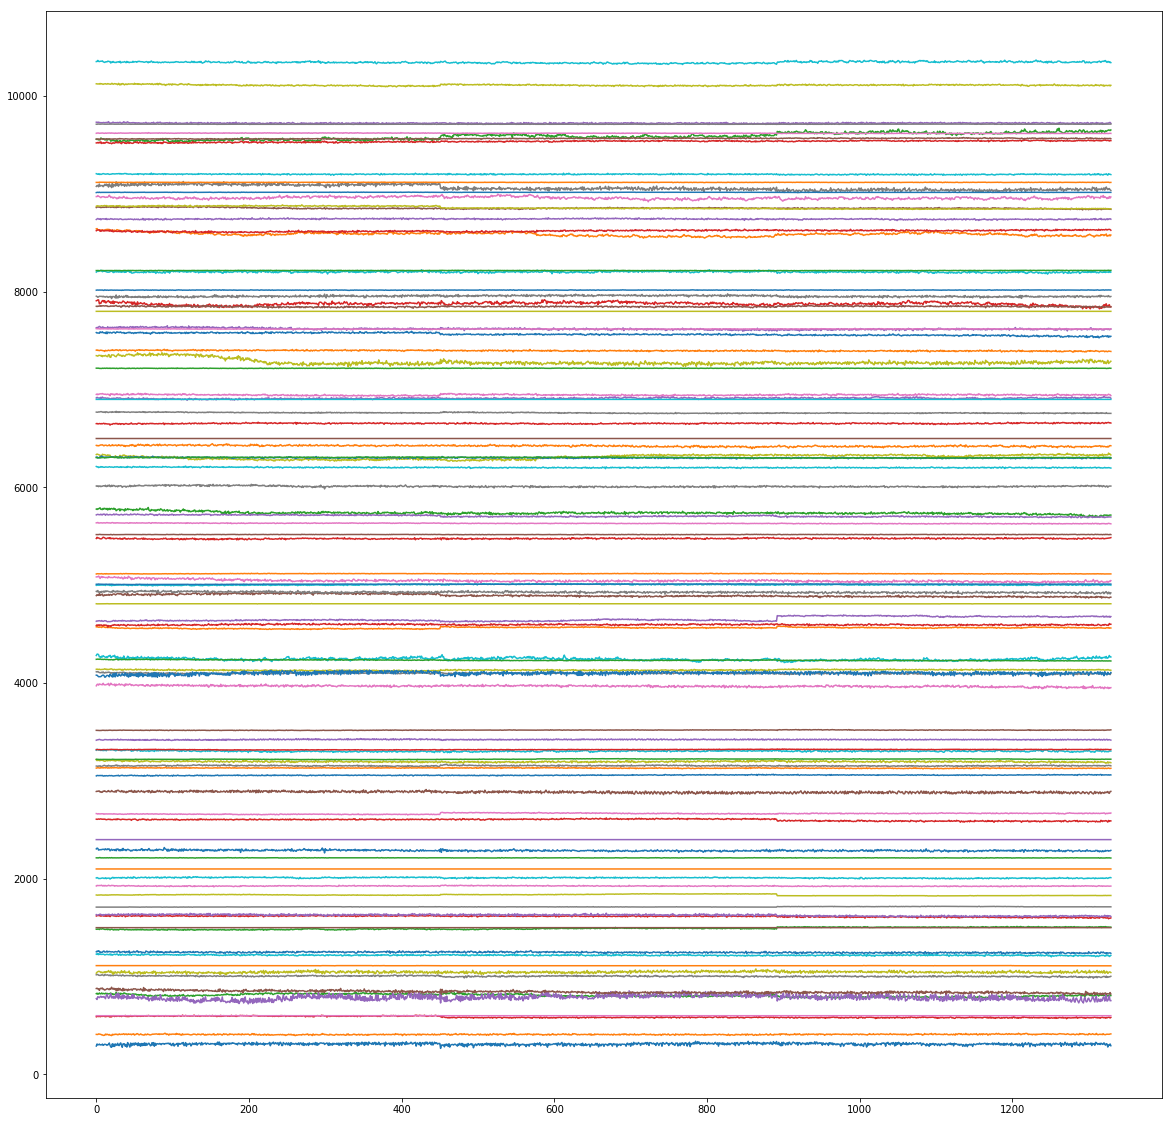

In [67]:
figure(figsize=(20,20))
for k in range(100):
    x = np.random.randint(mris.shape[0])
    y = np.random.randint(mris.shape[1])
    z = np.random.randint(mris.shape[2])
    plot(mris[x,y,z] + k * 100)
show()